In [1]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/srv/conda/lib/python3.6/site-packages/dask_kubernetes/config.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/srv/conda/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [2]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.2.32:37971 Dashboard: /user/0000-0001-7783-5629/proxy/39751/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import Wavenum_freq_spec_func as wfs


In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
from matplotlib.colors import LogNorm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [5]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')

gcsmapgrid=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/grid',gcs=fs,check=False,create=False)
dsgrid=xr.open_zarr(gcsmapgrid)


In [6]:

gcsmap=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/U',gcs=fs,check=False,create=False)
dsu=xr.open_zarr(gcsmap)

In [7]:

gcsmap=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/V',gcs=fs,check=False,create=False)
dsv=xr.open_zarr(gcsmap)

In [8]:
lat=dsgrid.sel(face=2)['YC']
lon=dsgrid.sel(face=2)['XC']


In [9]:
latmin = 40.0; latmax = 45.0;
lonmin = -40.0; lonmax = -35.0;


In [10]:
latbox=lat.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)
lonbox=lon.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)

In [20]:
u_JFM=dsu.sel(face=2,time=slice('2012-01-01','2012-03-31'))['U']
v_JFM=dsv.sel(face=2,time=slice('2012-01-01','2012-03-31'))['V']

u_JFM_i=u_JFM.rename({'i_g':'i'})
v_JFM_j=v_JFM.rename({'j_g':'j'})

u_JFM_box=u_JFM_i.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)
v_JFM_box=v_JFM_j.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)

# - remove NaN
u_JFM = u_JFM_box.interpolate_na(dim='j')
v_JFM = v_JFM_box.interpolate_na(dim='j')

# - get dx and dy
dx_JFM,dy_JFM = wfs.get_dx_dy(u_JFM[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JFM = wfs.detrendn(u_JFM,axes=[0,1,2])
v_JFM = wfs.detrendn(v_JFM,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JFM = wfs.apply_window(u_JFM, u_JFM.dims, window_type='hanning')
v_JFM = wfs.apply_window(v_JFM, v_JFM.dims, window_type='hanning')

u_JFMhat = xfft.fft(u_JFM, dim=('time', 'i', 'j'), dx={'i': dx, 'j': dx}, sym=True)
v_JFMhat = xfft.fft(v_JFM, dim=('time', 'i', 'j'), dx={'i': dx, 'j': dx}, sym=True)

u_JFM_psd = xfft.psd(u_JFMhat)
v_JFM_psd = xfft.psd(v_JFMhat)

frequency_JFM = u_JFMhat.f_time
kx_JFM = u_JFMhat.f_i
ky_JFM = u_JFMhat.f_j

wavenumber_JFM,kradial_JFM = wfs.get_wavnum_kradial(kx_JFM,ky_JFM)

#... Get numpy array ... 
print('Get numpy array')
u_JFM_psd_np = u_JFM_psd.values
v_JFM_psd_np = v_JFM_psd.values

u_JFM_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JFM,wavenumber_JFM,u_JFM_psd_np)
v_JFM_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JFM,wavenumber_JFM,v_JFM_psd_np)

KE_JFM_wavenum_freq_spectrum=0.5*(u_JFM_wavenum_freq_spectrum+v_JFM_wavenum_freq_spectrum)


/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


Detrend data in all dimension
Apply hanning windowing
Get numpy array
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


In [21]:
u_JAS=dsu.sel(face=2,time=slice('2012-06-01','2012-09-23'))['U']
v_JAS=dsv.sel(face=2,time=slice('2012-06-01','2012-09-23'))['V']

u_JAS_i=u_JAS.rename({'i_g':'i'})
v_JAS_j=v_JAS.rename({'j_g':'j'})

u_JAS_box=u_JAS_i.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)
v_JAS_box=v_JAS_j.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)

# - remove NaN
u_JAS = u_JAS_box.interpolate_na(dim='j')
v_JAS = v_JAS_box.interpolate_na(dim='j')

# - get dx and dy
dx_JAS,dy_JAS = wfs.get_dx_dy(u_JAS[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JAS = wfs.detrendn(u_JAS,axes=[0,1,2])
v_JAS = wfs.detrendn(v_JAS,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JAS = wfs.apply_window(u_JAS, u_JAS.dims, window_type='hanning')
v_JAS = wfs.apply_window(v_JAS, v_JAS.dims, window_type='hanning')

u_JAShat = xfft.fft(u_JAS, dim=('time', 'i', 'j'), dx={'i': dx, 'j': dx}, sym=True)
v_JAShat = xfft.fft(v_JAS, dim=('time', 'i', 'j'), dx={'i': dx, 'j': dx}, sym=True)

u_JAS_psd = xfft.psd(u_JAShat)
v_JAS_psd = xfft.psd(v_JAShat)

frequency_JAS = u_JAShat.f_time
kx_JAS = u_JAShat.f_i
ky_JAS = u_JAShat.f_j

wavenumber_JAS,kradial_JAS = wfs.get_wavnum_kradial(kx_JAS,ky_JAS)

#... Get numpy array ... 
print('Get numpy array')
u_JAS_psd_np = u_JAS_psd.values
v_JAS_psd_np = v_JAS_psd.values

u_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,u_JAS_psd_np)
v_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,v_JAS_psd_np)

KE_JAS_wavenum_freq_spectrum=0.5*(u_JAS_wavenum_freq_spectrum+v_JAS_wavenum_freq_spectrum)


/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


Detrend data in all dimension
Apply hanning windowing
Get numpy array
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


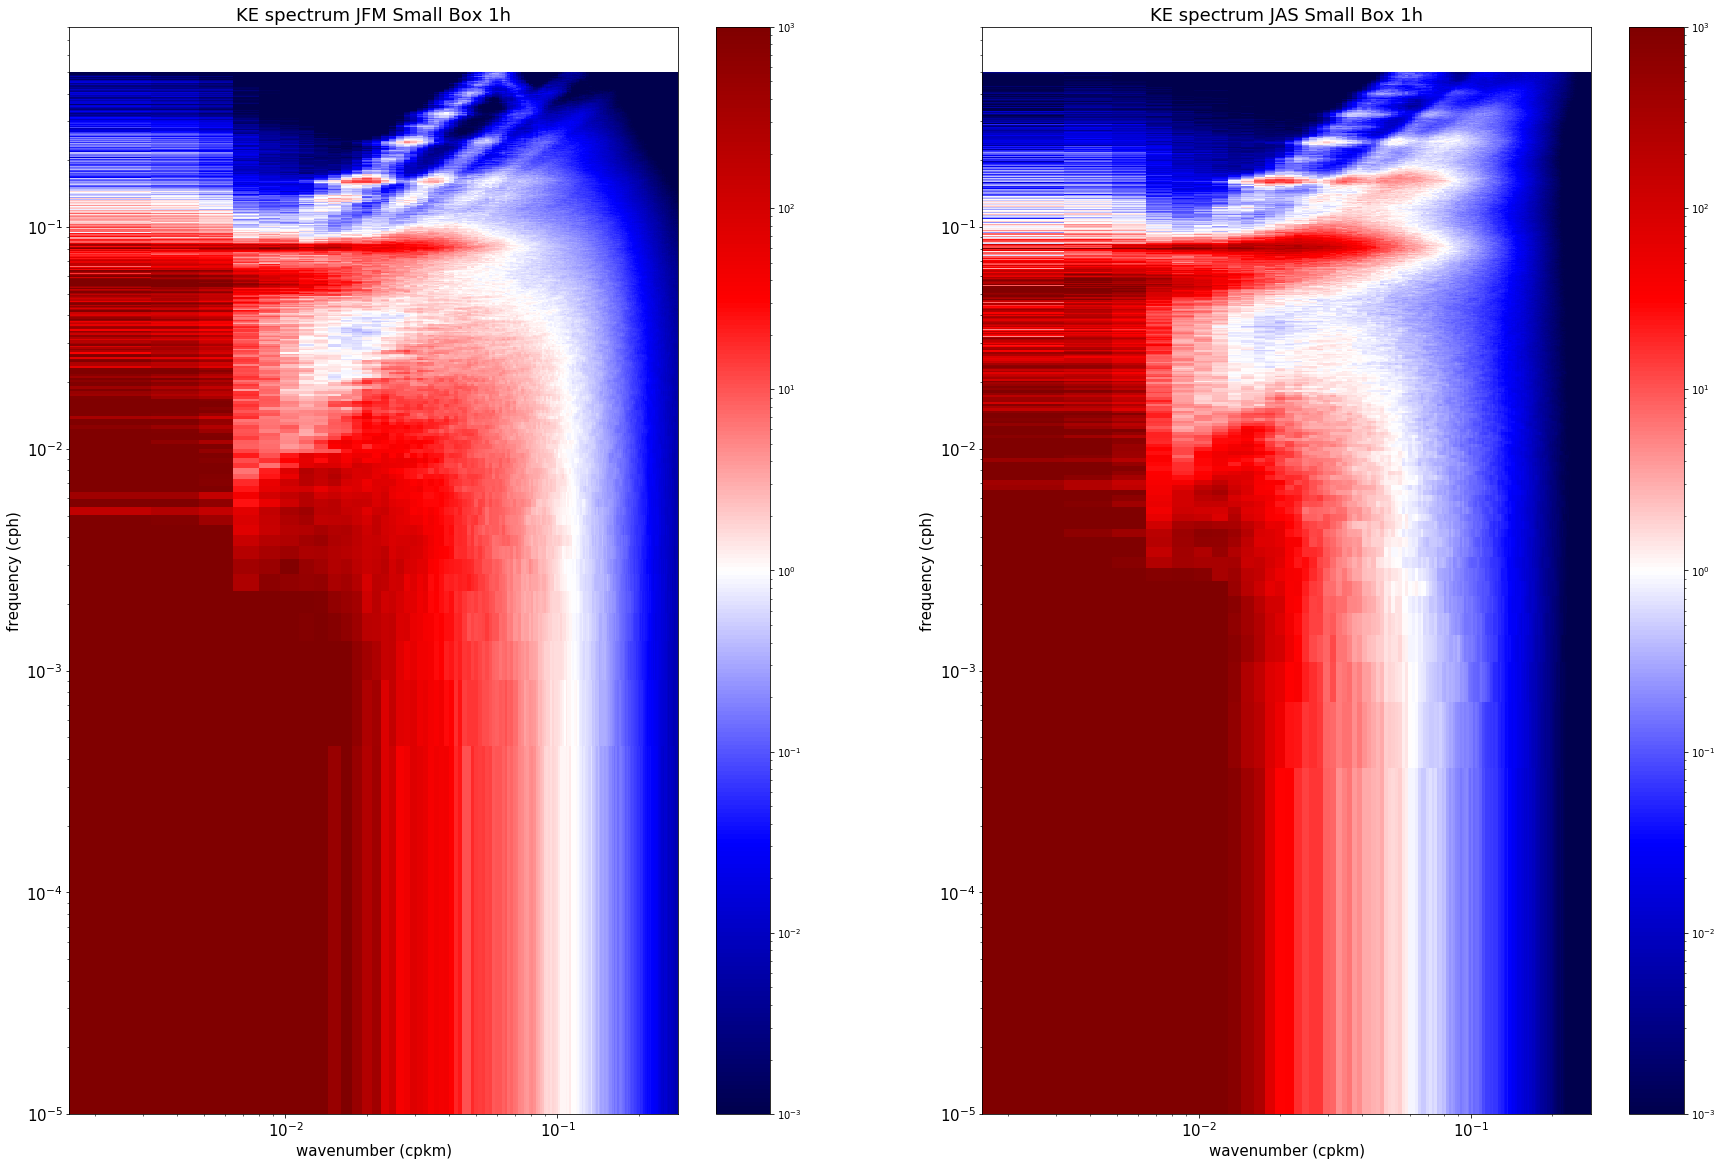

In [22]:
sec_to_hour = 3600.0
norm = LogNorm(vmin=0.001,vmax=1000)
cmap = div_cmap

fig=plt.figure(figsize=(30,20))

ax = plt.subplot(121)
plt.pcolormesh(wavenumber_JFM,sec_to_hour*frequency_JFM,KE_JFM_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JFM.min(),wavenumber_JFM.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JFM Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

ax = plt.subplot(122)
plt.pcolormesh(wavenumber_JAS,sec_to_hour*frequency_JAS,KE_JAS_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JAS.min(),wavenumber_JAS.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JAS Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()
